In [24]:
import pandas as pd 
import numpy as np
import math

In [25]:
res = pd.read_csv("results.csv")
res.rename(columns={'Unnamed: 0':'State'}, inplace=True)
res = res.iloc[:-1]

vader = pd.read_csv("statewise_total_idea1.csv")
vader.rename(columns={'Unnamed: 0':'State'}, inplace=True)

bnb = pd.read_csv("statewise_total_idea2.csv")
bnb.rename(columns={'Unnamed: 0':'State'}, inplace=True)

vader_subj = pd.read_csv("statewise_total_idea3.csv")
vader_subj.rename(columns={'Unnamed: 0':'State'}, inplace=True)

bnb_subj = pd.read_csv("statewise_total_idea4.csv")
bnb_subj.rename(columns={'Unnamed: 0':'State'}, inplace=True)

vader_bnb = pd.read_csv("statewise_total_idea5.csv")
vader_bnb.rename(columns={'Unnamed: 0':'State'}, inplace=True)

In [26]:
def get_sentiments(method):
    if method == "vader":
        df = vader
    elif method == "bnb":
        df = bnb
    elif method == "vader_subj":
        df = vader_subj
    elif method == "bnb_subj":
        df = bnb_subj
    elif method == "vader_bnb":
        df = vader_bnb
    df['Actual Biden Percentage'] = res['Biden Percentage']
    df['Actual Trump Percentage'] = res['Trump Percentage']
    df['Actual Winner'] = res["Winner"]
    df["Total Tweets"] = df["Trump Total count"] + df["Biden Total count"]
    return df

In [27]:
def getPreds(df, method):
    if method == 0:
        df['Biden prediction'] = df['Biden Total count'] / (df['Biden Total count'] + df['Trump Total count'])
        df['Trump prediction'] = df['Trump Total count'] / (df['Biden Total count'] + df['Trump Total count'])
    elif method == 1:
        df['Biden prediction'] = df['Biden Positive count']/(df['Trump Positive count'] + df['Biden Positive count'])
        df['Trump prediction'] = df['Trump Positive count']/(df['Trump Positive count'] + df['Biden Positive count'])
    elif method == 2:
        df['Biden prediction'] = df['Trump Negative count']/(df['Trump Negative count'] + df['Biden Negative count'])
        df['Trump prediction'] = df['Biden Negative count']/(df['Trump Negative count'] + df['Biden Negative count'])
    elif method == 3:
        trump_pos = df['Trump Positive count']/(df['Trump Total count'])
        biden_pos = df['Biden Positive count']/(df['Biden Total count'])
        df['Biden prediction'] = biden_pos/(trump_pos + biden_pos)
        df['Trump prediction'] = trump_pos/(trump_pos + biden_pos)
    elif method == 4:
        trump_neg = df['Biden Negative count']/(df['Biden Total count'])
        biden_neg = df['Trump Negative count']/(df['Trump Total count'])
        df['Biden prediction'] = trump_neg/(trump_neg + biden_neg)
        df['Trump prediction'] = biden_neg/(trump_neg + biden_neg)
    elif method == 5:
        trump_pos = df["Trump Positive Sum"]/(df["Trump Total Sum"])
        biden_pos = df["Biden Positive Sum"]/(df["Biden Total Sum"])
        df['Biden prediction'] = biden_pos/(trump_pos + biden_pos)
        df['Trump prediction'] = trump_pos/(trump_pos + biden_pos)
    return df

In [28]:
def kl_divergence(p,q):
    return sum(p[i] * math.log2(p[i]/q[i]) for i in range(len(p)))

def mae(p,q):
    return np.mean(np.abs(p[i] - q[i]) for i in range(len(p)))

In [29]:
def getMetrics(sentiment_method, pred_method):
    df = get_sentiments(sentiment_method)
    df = getPreds(df, pred_method)

    actual_biden = df['Actual Biden Percentage']
    predicted_biden = df['Biden prediction']
    actual_biden = actual_biden/actual_biden.sum()
    predicted_biden = predicted_biden/predicted_biden.sum()

    actual_trump = df['Actual Trump Percentage']
    predicted_trump = df['Trump prediction']
    actual_trump = actual_trump/actual_trump.sum()
    predicted_trump = predicted_trump/predicted_trump.sum()
    kl_div_biden = kl_divergence(actual_biden, predicted_biden)
    kl_div_trump = kl_divergence(actual_trump, predicted_trump)
    mae_biden = np.mean(np.abs(df['Actual Biden Percentage'] - df['Biden prediction']))
    mae_trump = np.mean(np.abs(df['Actual Trump Percentage'] - df['Trump prediction']))
    
    return kl_div_biden, kl_div_trump, mae_biden, mae_trump

In [30]:
sentiment_methods = ["vader", "bnb", "vader_subj", "bnb_subj", "vader_bnb"]
pred_methods = [0, 1, 2, 3, 4, 5]
results = {
    "sentiment_method": [],
    "pred_method": [],
    "kl_div_biden": [],
    "kl_div_trump": [],
    "mae_biden": [],
    "mae_trump": []
}
for sentiment in sentiment_methods:
    for pred in pred_methods:
        if pred == 5 and sentiment not in ["vader","vader_subj"]:
            continue
        kl_div_biden, kl_div_trump, mae_biden, mae_trump = getMetrics(sentiment, pred)
        results["sentiment_method"].append(sentiment)
        results["pred_method"].append(pred)
        results["kl_div_biden"].append(kl_div_biden)
        results["kl_div_trump"].append(kl_div_trump)
        results["mae_biden"].append(mae_biden)
        results["mae_trump"].append(mae_trump)

df = pd.DataFrame(results)

In [31]:
df

,sentiment_method,pred_method,kl_div_biden,kl_div_trump,mae_biden,mae_trump
0,vader,0,0.061935,0.048900,0.107118,0.106018
1,vader,1,0.061967,0.050688,0.105126,0.104526
2,vader,2,0.036122,0.040952,0.124954,0.112133
3,vader,3,0.032089,0.030404,0.083161,0.081540
4,vader,4,0.029756,0.026985,0.104944,0.094204
5,vader,5,0.028400,0.024941,0.087903,0.081429
6,bnb,0,0.061935,0.048900,0.107118,0.106018
7,bnb,1,0.053876,0.046232,0.106842,0.103398
8,bnb,2,0.035620,0.045091,0.132375,0.118849
9,bnb,3,0.031788,0.028482,0.092745,0.087722


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

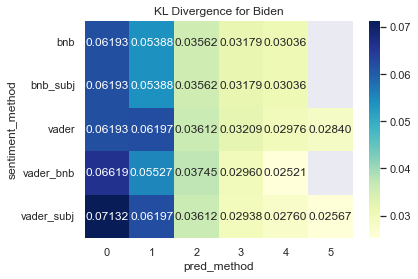

In [33]:
sns.heatmap(df.pivot(index='sentiment_method', columns='pred_method', values='kl_div_biden'), annot=True, fmt='.5f', cmap="YlGnBu")
plt.title("KL Divergence for Biden")
#plt.savefig("kl_divergence_biden.png", dpi=1000, bbox_inches='tight')
plt.show()

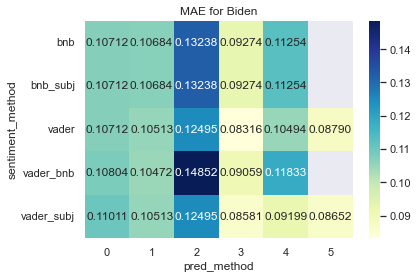

In [34]:
sns.heatmap(df.pivot(index='sentiment_method', columns='pred_method', values='mae_biden'), annot=True, fmt='.5f', cmap="YlGnBu")
plt.title("MAE for Biden")
#plt.savefig("mae_biden.png", dpi=1000, bbox_inches='tight')
plt.show()

In [35]:
df = get_sentiments("vader_subj")
df = getPreds(df, 5)

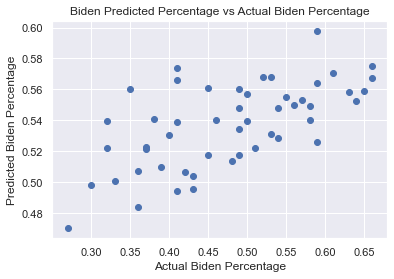

In [36]:
plt.scatter(df['Actual Biden Percentage'], df['Biden prediction'])
plt.xlabel('Actual Biden Percentage')
plt.ylabel('Predicted Biden Percentage')
plt.title('Biden Predicted Percentage vs Actual Biden Percentage')
plt.show()

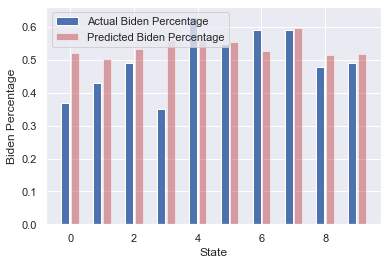

In [37]:
x = np.arange(0,len(df['Actual Biden Percentage']))
plt.bar(x[0:10]-0.15, df['Actual Biden Percentage'][0:10],width=0.25, label = 'Actual Biden Percentage')
plt.bar(x[0:10]+0.15, df['Biden prediction'][0:10], color='r', alpha=0.5,width=0.25, label= 'Predicted Biden Percentage')
plt.xlabel('State')
plt.ylabel('Biden Percentage')
plt.legend()
plt.savefig("preds.png",dpi=1000, bbox_inches='tight')
plt.show()

In [38]:
kl_div_biden, kl_div_trump, mae_biden, mae_trump = getMetrics("bnb_subj", 5)
kl_div_biden, kl_div_trump, mae_biden, mae_trump

(0.031513214318014036,
 0.02835856280278976,
 0.0935081952114255,
 0.08899513586161881)

In [39]:
seats_list = [9,3,11,6,55,9,7,3,29,16,4,4,20,11,6,6,8,8,4,10,11,16,10,6,10,3,5,6,4,14,5,29,15,3,18,7,7,20,4,9,3,11,38,6,3,13,12,5,10,3]

In [40]:
res_df = pd.read_csv("results.csv")

In [41]:
res_df.head()

,Unnamed: 0,Biden Count,Biden Percentage,Trump,Trump Percentage,Winner
0,Alabama,849624,0.37,1441170,0.62,Trump
1,Alaska,153778,0.43,189951,0.53,Trump
2,Arizona,1672143,0.49,1661686,0.49,Biden
3,Arkansas,423932,0.35,760647,0.62,Trump
4,California,11110250,0.63,6006429,0.34,Biden


In [42]:
total_biden_votes = res_df['Biden Count'].sum()
total_trump_votes = res_df['Trump'].sum()
total_votes = total_biden_votes + total_trump_votes

In [43]:
state_votes_map = {}
for i,row in res_df.iterrows():
    state_votes_map[row['Unnamed: 0']] = row['Trump'] + row['Biden Count'] 

In [44]:
predicted_biden_votes = 0
predicted_trump_votes = 0
for i in range(len(df)):
    state = df['State'][i]
    predicted_biden_votes += df['Biden prediction'][i] * state_votes_map[state]
    predicted_trump_votes += df['Trump prediction'][i] * state_votes_map[state]

In [45]:
total_predicted_votes = predicted_biden_votes + predicted_trump_votes

In [46]:
print("Actual results:")
print("Biden % votes: ", total_biden_votes/total_votes)
print("Trump % votes: ", total_trump_votes/total_votes)
print("#######################")
print("Predicted results:")
print("Biden % votes: ", predicted_biden_votes/total_predicted_votes)
print("Trump % votes: ", predicted_trump_votes/total_predicted_votes)


Actual results:
Biden % votes:  0.5217662558025045
Trump % votes:  0.4782337441974955
#######################
Predicted results:
Biden % votes:  0.5419369123806695
Trump % votes:  0.45806308761933034
